In [1]:
!pip install delu rtdl_revisiting_models

Looking in indexes: https://nexus.isb/repository/pypiorg-pypi-proxy/simple, https://nexus.isb/repository/deml-prod-pypi-hosted/simple


In [2]:
!pip install torch torchvision torchaudio

Looking in indexes: https://nexus.isb/repository/pypiorg-pypi-proxy/simple, https://nexus.isb/repository/deml-prod-pypi-hosted/simple


In [3]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import delu
from rtdl_revisiting_models import FTTransformer

from tqdm.std import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from functools import partial
import sklearn.model_selection
import sklearn.preprocessing
from sklearn.metrics import roc_auc_score, recall_score, precision_score, confusion_matrix, f1_score

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
pd.set_option('max_colwidth', 500)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### === Готовим данные для модели ===

In [5]:
df = pd.read_csv('iar_hse_data.csv')
df.head()

y = df[['target']]
X = df.drop(columns=['target'])

In [6]:
X_cat = X.select_dtypes(include=['object'])

X_cat = X_cat.apply(LabelEncoder().fit_transform)

X_float = X.select_dtypes(include=['float'])
X_int_float = X.select_dtypes(include=['int64']).astype(np.float32)
X_float = pd.concat([X_float, X_int_float], axis=1)
X_float = X_float.astype(np.float32)

float_features_cnt = X_float.shape[1]
cat_features_card = [X_cat[x].nunique() for x in X_cat.columns]

y = y.astype('float')

In [7]:
X_float = X_float.to_numpy()
X_cat = X_cat.to_numpy()
y = y.to_numpy()
y = y[:, 0]

In [8]:
n = len(df)
train_end = int(0.7 * n)
val_end = int(0.85 * n)

train_idx = np.arange(0, train_end)
val_idx = np.arange(train_end, val_end)
test_idx = np.arange(val_end, n)

In [9]:
data = {
    'train' : {'x_float':X_float[train_idx], 'x_cat':X_cat[train_idx], 'y':y[train_idx]},
    'val' : {'x_float':X_float[val_idx], 'x_cat':X_cat[val_idx], 'y':y[val_idx]},
    'test' : {'x_float':X_float[test_idx], 'x_cat':X_cat[test_idx], 'y':y[test_idx]}
}

In [10]:
preprocessing = sklearn.preprocessing.StandardScaler().fit(data['train']['x_float'])

for object in data:
    data[object]['x_float'] = preprocessing.transform(data[object]['x_float'])

In [11]:
tensors = {
    object: {k: torch.as_tensor(v, device=device) for k, v in data[object].items()} for object in data
}

### === Модель трансформера с row attention ===

In [12]:
class FeatureTokenizer(nn.Module):
    def __init__(self, n_cont_features, cat_cardinalities, embed_dim):
        super().__init__()
        self.cont_embedding = nn.Linear(1, embed_dim)
        self.cat_embeddings = nn.ModuleList([
            nn.Embedding(cardinality, embed_dim) for cardinality in cat_cardinalities
                                            ])
        self.n_cont_features = n_cont_features

    def forward(self, x_cont, x_cat):
        #континууальные признаки в эмбеддинги
        x_cont = x_cont.unsqueeze(-1) 
        x_cont = self.cont_embedding(x_cont)

        #категориальные — эмбеддинг каждого признака
        cat_embeds = [embed(x_cat[:, i]) for i, embed in enumerate(self.cat_embeddings)]
        x_cat = torch.stack(cat_embeds, dim=1)

        return torch.cat([x_cont, x_cat], dim=1)

In [13]:
class RowAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, n_heads, batch_first=True)

    def forward(self, x):
        x_t = x.transpose(0, 1)
        x_t, _ = self.attn(x_t, x_t, x_t)
        return x_t.transpose(0, 1)

In [14]:
class TransformerWithRowAttention(nn.Module):
    def __init__(self, n_cont_features, cat_cardinalities, d_out, embed_dim=128, n_heads=8):
        super().__init__()
        self.tokenizer = FeatureTokenizer(n_cont_features, cat_cardinalities, embed_dim)
        self.row_attn = RowAttention(embed_dim, n_heads)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=n_heads, batch_first=True),
            num_layers=2
        )
        self.head = nn.Linear(embed_dim, d_out)

    def forward(self, x_cont, x_cat):
        x = self.tokenizer(x_cont, x_cat)
        x = self.row_attn(x)              
        x = self.transformer(x)           
        x = x.mean(dim=1)                
        return self.head(x).squeeze(-1)  

In [17]:
model = TransformerWithRowAttention(
    n_cont_features=float_features_cnt,
    cat_cardinalities=cat_features_card,
    d_out=1,
    embed_dim=128,
    n_heads=8
).to(device)


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [17]:
pos_weight = 5 #тк дисбаланс
loss_func = nn.BCEWithLogitsLoss(pos_weight = torch.tensor(pos_weight))

In [19]:
def apply_model(batch):
    return model(batch['x_float'], batch['x_cat']).squeeze(-1)

In [21]:
def evaluate(part, eval_batch_size):
    model.eval()
    with torch.inference_mode():
        y_pred = (
            torch.cat(
                [
                    apply_model(batch) for batch in delu.iter_batches(tensors[part], eval_batch_size)
                ]
            )
            .cpu()
        )
        y_true = tensors[part]['y'].cpu().numpy()

        y_pred = torch.sigmoid(y_pred).numpy()
        test_y_pred = y_pred
        y_pred = np.where(y_pred>=0.85, 1, 0)
        score = sklearn.metrics.roc_auc_score(y_true, test_y_pred)
        precision = sklearn.metrics.precision_score(y_true, y_pred)
        recall = sklearn.metrics.recall_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred)
    return score, precision, recall, cm

In [22]:
n_epochs = 50
patience = 100

eval_batch_size = 512
batch_size = 512
epoch_size = math.ceil(len(train_idx) / batch_size)
timer = delu.tools.Timer()
early_stopping = delu.tools.EarlyStopping(patience, mode='max')

print(f"Device: {device}")
print("-" * 88 + "\n")
timer.run()
for epoch in range(n_epochs):
    for batch in tqdm(
        delu.iter_batches(tensors['train'], batch_size, shuffle=True),
        desc=f"Epoch {epoch}",
        total=epoch_size,
    ):
        model.train()
        optimizer.zero_grad()
        loss = loss_func(apply_model(batch), batch['y'])
        loss.backward()
        optimizer.step()

    val_score, val_precision, val_recall, prob_val = evaluate('val', eval_batch_size)
    print(f"Rocauc: (val) {val_score:.4f} [time] {timer}")
    print(f"Precision: (val) {val_precision:.4f} [time] {timer}")
    print(f"Recall: (val) {val_recall:.4f} [time] {timer}")

    early_stopping.update(val_score)
    if early_stopping.should_stop():
        break

    print()

Device: cpu
----------------------------------------------------------------------------------------



Epoch 0: 100%|██████████| 411/411 [00:36<00:00, 11.22it/s]


Rocauc: (val) 0.7827 [time] 0:00:38.582248
Precision: (val) 0.4687 [time] 0:00:38.582338
Recall: (val) 0.2306 [time] 0:00:38.582351



Epoch 1: 100%|██████████| 411/411 [00:35<00:00, 11.48it/s]


Rocauc: (val) 0.7863 [time] 0:01:16.323318
Precision: (val) 0.4720 [time] 0:01:16.323408
Recall: (val) 0.2407 [time] 0:01:16.323420



Epoch 2: 100%|██████████| 411/411 [00:35<00:00, 11.49it/s]


Rocauc: (val) 0.7908 [time] 0:01:54.269043
Precision: (val) 0.4666 [time] 0:01:54.269128
Recall: (val) 0.3050 [time] 0:01:54.269140



Epoch 3: 100%|██████████| 411/411 [00:35<00:00, 11.60it/s]


Rocauc: (val) 0.7924 [time] 0:02:31.583047
Precision: (val) 0.4884 [time] 0:02:31.583135
Recall: (val) 0.2494 [time] 0:02:31.583147



Epoch 4: 100%|██████████| 411/411 [00:35<00:00, 11.61it/s]


Rocauc: (val) 0.7921 [time] 0:03:08.838215
Precision: (val) 0.4936 [time] 0:03:08.838295
Recall: (val) 0.2342 [time] 0:03:08.838308



Epoch 5: 100%|██████████| 411/411 [00:35<00:00, 11.61it/s]


Rocauc: (val) 0.7951 [time] 0:03:46.557834
Precision: (val) 0.5294 [time] 0:03:46.557917
Recall: (val) 0.1996 [time] 0:03:46.557929



Epoch 6: 100%|██████████| 411/411 [00:35<00:00, 11.67it/s]


Rocauc: (val) 0.7949 [time] 0:04:23.767551
Precision: (val) 0.5095 [time] 0:04:23.767637
Recall: (val) 0.2412 [time] 0:04:23.767649



Epoch 7: 100%|██████████| 411/411 [00:35<00:00, 11.49it/s]


Rocauc: (val) 0.7966 [time] 0:05:01.448185
Precision: (val) 0.5516 [time] 0:05:01.448271
Recall: (val) 0.1868 [time] 0:05:01.448283



Epoch 8: 100%|██████████| 411/411 [00:35<00:00, 11.64it/s]


Rocauc: (val) 0.7964 [time] 0:05:38.596794
Precision: (val) 0.5008 [time] 0:05:38.596875
Recall: (val) 0.2696 [time] 0:05:38.596887



Epoch 9: 100%|██████████| 411/411 [00:35<00:00, 11.60it/s]


Rocauc: (val) 0.7991 [time] 0:06:16.079713
Precision: (val) 0.5187 [time] 0:06:16.079798
Recall: (val) 0.2348 [time] 0:06:16.079810



Epoch 10: 100%|██████████| 411/411 [00:35<00:00, 11.60it/s]


Rocauc: (val) 0.8007 [time] 0:06:53.356570
Precision: (val) 0.5460 [time] 0:06:53.356655
Recall: (val) 0.2081 [time] 0:06:53.356666



Epoch 11: 100%|██████████| 411/411 [00:35<00:00, 11.58it/s]


Rocauc: (val) 0.7985 [time] 0:07:30.963200
Precision: (val) 0.5632 [time] 0:07:30.963283
Recall: (val) 0.1835 [time] 0:07:30.963294



Epoch 12: 100%|██████████| 411/411 [00:34<00:00, 11.74it/s]


Rocauc: (val) 0.8003 [time] 0:08:07.836410
Precision: (val) 0.5101 [time] 0:08:07.836495
Recall: (val) 0.2701 [time] 0:08:07.836513



Epoch 13: 100%|██████████| 411/411 [00:34<00:00, 11.79it/s]


Rocauc: (val) 0.8017 [time] 0:08:44.535900
Precision: (val) 0.5029 [time] 0:08:44.535983
Recall: (val) 0.2870 [time] 0:08:44.535995



Epoch 14: 100%|██████████| 411/411 [00:35<00:00, 11.58it/s]


Rocauc: (val) 0.8026 [time] 0:09:22.202151
Precision: (val) 0.5322 [time] 0:09:22.202236
Recall: (val) 0.2355 [time] 0:09:22.202248



Epoch 15: 100%|██████████| 411/411 [00:35<00:00, 11.67it/s]


Rocauc: (val) 0.8004 [time] 0:09:59.422634
Precision: (val) 0.5542 [time] 0:09:59.422717
Recall: (val) 0.2220 [time] 0:09:59.422730



Epoch 16: 100%|██████████| 411/411 [00:35<00:00, 11.55it/s]


Rocauc: (val) 0.8015 [time] 0:10:36.829688
Precision: (val) 0.5374 [time] 0:10:36.829770
Recall: (val) 0.2343 [time] 0:10:36.829783



Epoch 17: 100%|██████████| 411/411 [00:35<00:00, 11.62it/s]


Rocauc: (val) 0.8037 [time] 0:11:14.043972
Precision: (val) 0.5300 [time] 0:11:14.044058
Recall: (val) 0.2647 [time] 0:11:14.044070



Epoch 18: 100%|██████████| 411/411 [00:35<00:00, 11.72it/s]


Rocauc: (val) 0.8030 [time] 0:11:51.203454
Precision: (val) 0.5106 [time] 0:11:51.203545
Recall: (val) 0.2926 [time] 0:11:51.203558



Epoch 19: 100%|██████████| 411/411 [00:35<00:00, 11.60it/s]


Rocauc: (val) 0.8001 [time] 0:12:28.428207
Precision: (val) 0.5200 [time] 0:12:28.428292
Recall: (val) 0.2558 [time] 0:12:28.428304



Epoch 20: 100%|██████████| 411/411 [00:35<00:00, 11.71it/s]


Rocauc: (val) 0.8033 [time] 0:13:05.720337
Precision: (val) 0.5156 [time] 0:13:05.720421
Recall: (val) 0.2871 [time] 0:13:05.720433



Epoch 21: 100%|██████████| 411/411 [00:35<00:00, 11.68it/s]


Rocauc: (val) 0.8032 [time] 0:13:42.725350
Precision: (val) 0.5457 [time] 0:13:42.725433
Recall: (val) 0.2379 [time] 0:13:42.725446



Epoch 22: 100%|██████████| 411/411 [00:35<00:00, 11.73it/s]


Rocauc: (val) 0.8039 [time] 0:14:19.629373
Precision: (val) 0.5579 [time] 0:14:19.629453
Recall: (val) 0.2371 [time] 0:14:19.629465



Epoch 23: 100%|██████████| 411/411 [00:35<00:00, 11.73it/s]


Rocauc: (val) 0.8057 [time] 0:14:56.488517
Precision: (val) 0.5441 [time] 0:14:56.488598
Recall: (val) 0.2396 [time] 0:14:56.488611



Epoch 24: 100%|██████████| 411/411 [00:35<00:00, 11.65it/s]


Rocauc: (val) 0.8038 [time] 0:15:33.611219
Precision: (val) 0.5227 [time] 0:15:33.611299
Recall: (val) 0.2817 [time] 0:15:33.611311



Epoch 25: 100%|██████████| 411/411 [00:35<00:00, 11.48it/s]


Rocauc: (val) 0.8028 [time] 0:16:11.535819
Precision: (val) 0.5388 [time] 0:16:11.535903
Recall: (val) 0.2540 [time] 0:16:11.535915



Epoch 26: 100%|██████████| 411/411 [00:35<00:00, 11.67it/s]


Rocauc: (val) 0.8042 [time] 0:16:48.572791
Precision: (val) 0.5501 [time] 0:16:48.572873
Recall: (val) 0.2312 [time] 0:16:48.572884



Epoch 27: 100%|██████████| 411/411 [00:35<00:00, 11.67it/s]


Rocauc: (val) 0.8042 [time] 0:17:25.608951
Precision: (val) 0.5499 [time] 0:17:25.609035
Recall: (val) 0.2404 [time] 0:17:25.609047



Epoch 28: 100%|██████████| 411/411 [00:35<00:00, 11.73it/s]


Rocauc: (val) 0.8055 [time] 0:18:02.529877
Precision: (val) 0.5497 [time] 0:18:02.529961
Recall: (val) 0.2496 [time] 0:18:02.529972



Epoch 29: 100%|██████████| 411/411 [00:35<00:00, 11.58it/s]


Rocauc: (val) 0.8054 [time] 0:18:39.934548
Precision: (val) 0.5449 [time] 0:18:39.934636
Recall: (val) 0.2586 [time] 0:18:39.934649



Epoch 30: 100%|██████████| 411/411 [00:36<00:00, 11.40it/s]


Rocauc: (val) 0.8045 [time] 0:19:17.856908
Precision: (val) 0.5194 [time] 0:19:17.856989
Recall: (val) 0.2857 [time] 0:19:17.857001



Epoch 31: 100%|██████████| 411/411 [00:35<00:00, 11.45it/s]


Rocauc: (val) 0.8028 [time] 0:19:55.620769
Precision: (val) 0.5553 [time] 0:19:55.620849
Recall: (val) 0.2314 [time] 0:19:55.620862



Epoch 32: 100%|██████████| 411/411 [00:35<00:00, 11.47it/s]


Rocauc: (val) 0.8055 [time] 0:20:33.310006
Precision: (val) 0.5546 [time] 0:20:33.310091
Recall: (val) 0.2289 [time] 0:20:33.310103



Epoch 33: 100%|██████████| 411/411 [00:35<00:00, 11.47it/s]


Rocauc: (val) 0.8053 [time] 0:21:11.286972
Precision: (val) 0.5435 [time] 0:21:11.287057
Recall: (val) 0.2663 [time] 0:21:11.287068



Epoch 34: 100%|██████████| 411/411 [00:35<00:00, 11.50it/s]


Rocauc: (val) 0.8045 [time] 0:21:49.149152
Precision: (val) 0.5255 [time] 0:21:49.149237
Recall: (val) 0.2785 [time] 0:21:49.149249



Epoch 35: 100%|██████████| 411/411 [00:35<00:00, 11.59it/s]


Rocauc: (val) 0.8048 [time] 0:22:26.511637
Precision: (val) 0.5487 [time] 0:22:26.511719
Recall: (val) 0.2376 [time] 0:22:26.511731



Epoch 36: 100%|██████████| 411/411 [00:35<00:00, 11.60it/s]


Rocauc: (val) 0.8051 [time] 0:23:04.003978
Precision: (val) 0.5278 [time] 0:23:04.004063
Recall: (val) 0.2899 [time] 0:23:04.004075



Epoch 37: 100%|██████████| 411/411 [00:35<00:00, 11.42it/s]


Rocauc: (val) 0.8040 [time] 0:23:41.920228
Precision: (val) 0.5369 [time] 0:23:41.920312
Recall: (val) 0.2611 [time] 0:23:41.920324



Epoch 38: 100%|██████████| 411/411 [00:36<00:00, 11.41it/s]


Rocauc: (val) 0.8008 [time] 0:24:19.996315
Precision: (val) 0.5397 [time] 0:24:19.996399
Recall: (val) 0.2384 [time] 0:24:19.996411



Epoch 39: 100%|██████████| 411/411 [00:35<00:00, 11.66it/s]


Rocauc: (val) 0.8051 [time] 0:24:57.145494
Precision: (val) 0.5336 [time] 0:24:57.145586
Recall: (val) 0.2722 [time] 0:24:57.145598



Epoch 40: 100%|██████████| 411/411 [00:34<00:00, 11.94it/s]


Rocauc: (val) 0.8051 [time] 0:25:33.399183
Precision: (val) 0.5204 [time] 0:25:33.399269
Recall: (val) 0.2809 [time] 0:25:33.399281



Epoch 41: 100%|██████████| 411/411 [00:35<00:00, 11.73it/s]


Rocauc: (val) 0.8032 [time] 0:26:10.306683
Precision: (val) 0.5501 [time] 0:26:10.306788
Recall: (val) 0.2378 [time] 0:26:10.306805



Epoch 42: 100%|██████████| 411/411 [00:35<00:00, 11.69it/s]


Rocauc: (val) 0.8053 [time] 0:26:47.604829
Precision: (val) 0.5458 [time] 0:26:47.604912
Recall: (val) 0.2580 [time] 0:26:47.604924



Epoch 43: 100%|██████████| 411/411 [00:34<00:00, 11.84it/s]


Rocauc: (val) 0.8042 [time] 0:27:24.455548
Precision: (val) 0.5520 [time] 0:27:24.455631
Recall: (val) 0.2524 [time] 0:27:24.455643



Epoch 44: 100%|██████████| 411/411 [00:34<00:00, 11.90it/s]


Rocauc: (val) 0.8046 [time] 0:28:00.818042
Precision: (val) 0.5308 [time] 0:28:00.818130
Recall: (val) 0.2799 [time] 0:28:00.818142



Epoch 45: 100%|██████████| 411/411 [00:34<00:00, 11.89it/s]


Rocauc: (val) 0.8047 [time] 0:28:37.208117
Precision: (val) 0.5774 [time] 0:28:37.208204
Recall: (val) 0.2171 [time] 0:28:37.208216



Epoch 46: 100%|██████████| 411/411 [00:35<00:00, 11.73it/s]


Rocauc: (val) 0.8030 [time] 0:29:14.127081
Precision: (val) 0.5350 [time] 0:29:14.127163
Recall: (val) 0.2655 [time] 0:29:14.127175



Epoch 47: 100%|██████████| 411/411 [00:34<00:00, 11.75it/s]


Rocauc: (val) 0.8041 [time] 0:29:51.157525
Precision: (val) 0.5441 [time] 0:29:51.157642
Recall: (val) 0.2529 [time] 0:29:51.157662



Epoch 48: 100%|██████████| 411/411 [00:34<00:00, 11.79it/s]


Rocauc: (val) 0.8047 [time] 0:30:28.305240
Precision: (val) 0.5761 [time] 0:30:28.305326
Recall: (val) 0.2297 [time] 0:30:28.305338



Epoch 49: 100%|██████████| 411/411 [00:34<00:00, 11.83it/s]


Rocauc: (val) 0.8031 [time] 0:31:04.898350
Precision: (val) 0.5389 [time] 0:31:04.898433
Recall: (val) 0.2591 [time] 0:31:04.898446



### === Наилучший порог по графику ===

In [23]:
def plot_precision_recall_curve(y_true, y_proba):
    thresholds = np.linspace(0.01, 0.99, 100)
    precisions = []
    recalls = []
    f1s = []

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        precisions.append(precision_score(y_true, y_pred, zero_division=0))
        recalls.append(recall_score(y_true, y_pred))
        f1s.append(f1_score(y_true, y_pred, zero_division=0))

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions, label='Precision')
    plt.plot(thresholds, recalls, label='Recall')
    plt.plot(thresholds, f1s, label='F1-score')
    plt.xlabel('Порог вероятности')
    plt.ylabel('Значение метрики')
    plt.title('Зависимость Precision / Recall / F1 от порога')
    plt.legend()
    plt.grid(True)
    plt.show()

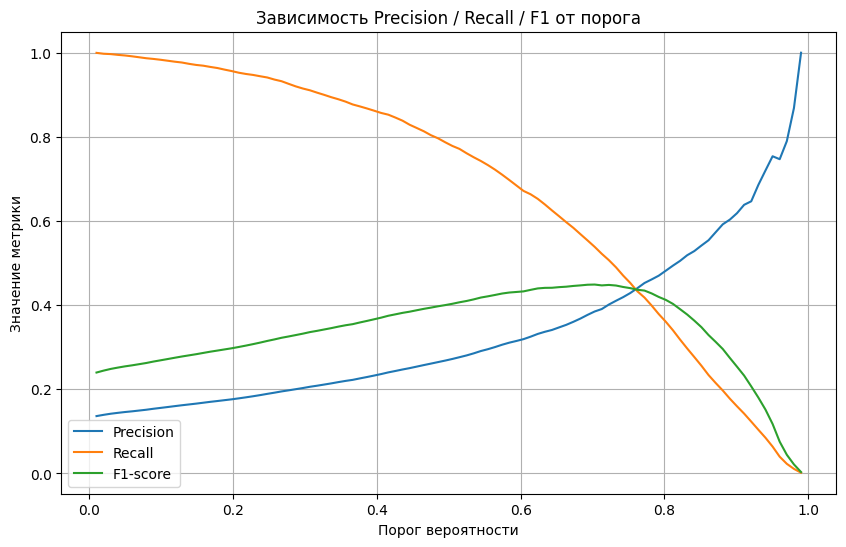

In [24]:
model.eval()
with torch.no_grad():
    val_logits = model(tensors['val']['x_float'], tensors['val']['x_cat'])
    val_proba = torch.sigmoid(val_logits).cpu().numpy()
    val_true = tensors['val']['y'].cpu().numpy()

plot_precision_recall_curve(val_true, val_proba)

##### считаю, что порог 0.9 подходит для корректного среза false positive решений

### === Оценка качества на тесте с подходящим трешхолдом ===

In [34]:
test_score, test_precision, test_recall, prob_test= evaluate('test', eval_batch_size)
print(f"Rocauc: (test) {test_score:.4f}")
print(f"Precision: (test) {test_precision:.4f}")
print(f"Recall: (test) {test_recall:.4f}")

Rocauc: (test) 0.8052
Precision: (test) 0.5964
Recall: (test) 0.1536


In [35]:
def flow_cut(y_prob, threshold):
    return (y_prob >= threshold).mean()

In [36]:
model.eval()
with torch.no_grad():
    test_proba = torch.sigmoid(model(tensors['test']['x_float'], tensors['test']['x_cat'])).cpu().numpy()
y_true = tensors['test']['y'].cpu().numpy()

In [37]:
print(f"Flow cut with best threshold: {flow_cut(test_proba, 0.9):.4f}")

Flow cut with best threshold: 0.0312


##### Метрики,если срез в 4%

In [38]:
def get_threshold_for_top_percent(y_proba, top_percent=0.04):
    k = int(len(y_proba) * top_percent)
    sorted_proba = np.sort(y_proba, axis=0)
    return sorted_proba[-k]

In [39]:
threshold_4pct = get_threshold_for_top_percent(test_proba, top_percent=0.04)
y_pred_top4 = (test_proba >= threshold_4pct[0]).astype(int)

#метрики в этом срезе:
precision = precision_score(y_true, y_pred_top4)
recall = recall_score(y_true, y_pred_top4)
stream_cut = (y_pred_top4 == 1).mean()

print(f"Threshold @ top 4%: {threshold_4pct[0]:.4f}")
print(f"Precision@4%: {precision:.4f}")
print(f"Recall@4%:    {recall:.4f}")
print(f"Отсечено:     {stream_cut*100:.2f}% заявок")

Threshold @ top 4%: 0.8830
Precision@4%: 0.5600
Recall@4%:    0.1848
Отсечено:     4.00% заявок


### === Важность фичей ===

In [40]:
def permutation_importance(model, tensors, feature_names=None, part='val'):
    model.eval()

    x_float = tensors[part]['x_float'].clone()
    x_cat = tensors[part]['x_cat'].clone()
    y_true = tensors[part]['y'].cpu().numpy()

    with torch.no_grad():
        base_preds = torch.sigmoid(model(x_float, x_cat)).cpu().numpy()
    baseline_auc = roc_auc_score(y_true, base_preds)

    importances = []
    names = []

    # Перемешиваем числовые признаки
    for i in range(x_float.shape[1]):
        x_float_perm = x_float.clone()
        x_float_perm[:, i] = x_float_perm[torch.randperm(len(x_float_perm)), i]
        with torch.no_grad():
            preds = torch.sigmoid(model(x_float_perm, x_cat)).cpu().numpy()
        auc = roc_auc_score(y_true, preds)
        importances.append(baseline_auc - auc)
        if feature_names:
            names.append(feature_names['float'][i])
        else:
            names.append(f'float_{i}')

    # Перемешиваем категориальные признаки
    for i in range(x_cat.shape[1]):
        x_cat_perm = x_cat.clone()
        x_cat_perm[:, i] = x_cat_perm[torch.randperm(len(x_cat_perm)), i]
        with torch.no_grad():
            preds = torch.sigmoid(model(x_float, x_cat_perm)).cpu().numpy()
        auc = roc_auc_score(y_true, preds)
        importances.append(baseline_auc - auc)
        if feature_names:
            names.append(feature_names['cat'][i])
        else:
            names.append(f'cat_{i}')

    return importances, names

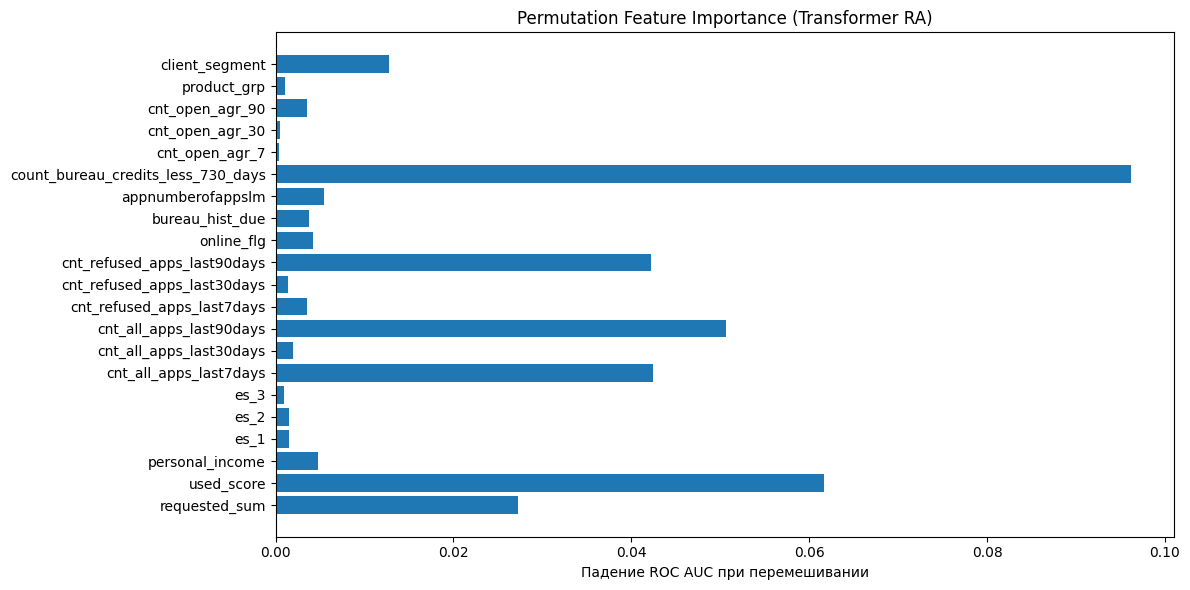

In [42]:
X_cat_df = X.select_dtypes(include=['object'])
X_float_df = X.select_dtypes(include=['float'])
X_int_float_df = X.select_dtypes(include=['int64']).astype(np.float32)
X_float_df = pd.concat([X_float_df, X_int_float_df], axis=1)

feature_names = {
    'float': list(X_float_df.columns),
    'cat': list(X_cat_df.columns),
}

importances, names = permutation_importance(model, tensors, feature_names=feature_names)

plt.figure(figsize=(12, 6))
plt.barh(names, importances)
plt.title("Permutation Feature Importance (Transformer RA)")
plt.xlabel("Падение ROC AUC при перемешивании")
plt.tight_layout()
plt.show()